# ADAML workshop 3: Recurrent Neural Network



___

## Model implementation

(1200, 20, 1) (1200, 1)

Test MSE: 0.021607



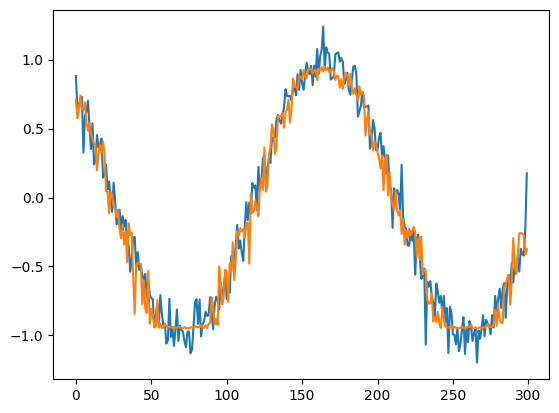

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class RNN:
    def __init__(self, input_size, hidden_size, output_size, lr=1e-3, seed=1):
        rng = np.random.RandomState(seed)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.lr = lr
        self.Wxh = rng.randn(hidden_size, input_size)
        self.Whh = rng.randn(hidden_size, hidden_size)
        self.Why = rng.randn(output_size, hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    # In forward model we feed the data X through the network
    def forward(self, X: np.ndarray): 
        assert X.ndim == 3, "X must be a 3D matrix"
        
        # Determine batch size and sequence length
        batch, seq_len, _ = X.shape

        # Initialize hidden state
        h = np.zeros((batch, seq_len+1, self.hidden_size))

        # Propagate the input trough hidden layers
        for t in range(seq_len): 

            # Reshape the input
            xt = X[:, t, :].reshape(batch, 1)

            # Compute the hidden layer output.T
            pre = xt.dot(self.Wxh.T) + h[:, t, :].dot(self.Whh.T) + self.bh.T
            h[:, t+1, :] = np.tanh(pre) # Apply activation function to hidden state (here, tanh is used)

            # Compute the output 
            y_pred = h[:, -1, :].dot(self.Why.T) + self.by

        # Return hidden state and predicted output
        return h, y_pred

    # Compute the Mean Square Error loss
    def loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        diff = y_true - y_pred
        return np.mean(diff**2), diff

    # Backpropagation
    def bptt_update(self, X, h, y_pred, y_true):
        # Using backpropagation through time (bptt) to update the weights
        # X: (batch, seq_len, input_size)

        batch_size, seq_len, _ = X.shape

        # Init the gradients
        dWxh, dWhh, dWhy= np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)

        # Compute the gradient of the output wrt. loss
        dy = (y_pred - y_true) * (2.0 / batch_size)

        h_lash = h[:, -1, :].reshape(batch_size, self.hidden_size)

        # Compute the gradients of the loss wrt. output layer weights and biases
        dWhy += dy.T.dot(h_lash)
        dby += dy.T.sum(axis=1, keepdims=True)

        # Compute the gradient of the loss wrt the hidden state
        dh_next = dy.dot(self.Why)

        for t in reversed(range(seq_len)): 
            ht = h[:, t+1, :]
            ht_prev = h[:, t, : ]

            # Gradient of the activation function (tanh) and hidden biases
            dt = dh_next*(1 - ht**2)
            dbh = dt.T.sum(axis=1, keepdims=True)

            # Get inputs at t
            xt = X[:, t, :].reshape(batch_size, -1)

            # Comute the gradients of the hidden weights and hidden state
            dWxh += dt.T.dot(xt)
            dWhh += dt.T.dot(ht_prev)

            # Compute the gradient that is propagated to the next time step 
            dh_next = dt.dot(self.Whh)

        # Clip the gradients for numerical stability
        for grad in (dWhh, dWxh, dWhy, dbh, dby): 
            np.clip(grad, -5, 5, out=grad)

        # Update the parameters
        self.Wxh -= self.lr * dWxh
        self.Whh -= self.lr * dWhh
        self.Why -= self.lr * dWhy
        self.bh -= self.lr * dbh
        self.by -= self.lr * dby
        return 

    def train(self, X, y, epochs=50, batch_size=32, verbose=True):
        #assert X.ndim == 3 and len(y) == y.size, 'X must be a 3D matrix and y must be a vector'
        assert len(X) == len(y), 'X and y must be the same length'
        
        # Length of X
        n = X.shape[0]
        losses=[]

        # Training loop
        for epoch in range(1, epochs + 1): 

            # Shuffle the indices
            idx = np.random.permutation(n)
            X_shuffled, y_shuffled = X[idx], y[idx]

            # Iterate over batches
            loss_epoch = 0.0
            for i in range(0, n, batch_size): 

                # Take one batch
                X_batch, y_batch = X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]

                # Forward propagate the batch
                h, y_pred = self.forward(X_batch)

                # Compute model loss
                loss, _ = self.loss(y_pred, y_batch)
                loss_epoch += loss * X_batch.shape[0]

                # Compute the gradient wrt. loss and backward propagate
                self.bptt_update(X_batch, h, y_pred, y_batch)

            # Normalize the loss
            loss_epoch /= n
            losses.append(loss_epoch)

        # Return the loss history
        return losses

def generate_sine_sequences(n_samples=2000, seq_len=20, input_size=1, seed=0):
    rng = np.random.RandomState(seed)
    x = np.linspace(0, 50, n_samples * seq_len * input_size)
    data = np.sin(x) + 0.1 * rng.randn(n_samples * seq_len * input_size)
    X = data.reshape(n_samples, seq_len, input_size)
    rolled = np.roll(data, -1).reshape(n_samples, seq_len, input_size)
    y_last = rolled[:, -1, :]
    return X.astype(np.float32), y_last.astype(np.float32)

# Creating the data
X, y = generate_sine_sequences(n_samples=1500, seq_len=20, input_size=1)
# train/test split
split = int(0.8 * X.shape[0])
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print(X_train.shape, y_train.shape)

# Training the network
rnn = RNN(input_size=1, hidden_size=80, output_size=1, lr=1e-3)
losses = rnn.train(X_train, y_train, epochs=600, batch_size=8, verbose=True)

# Test set
_, y_pred_test = rnn.forward(X_test)
test_loss, _ = rnn.loss(y_pred_test, y_test)
print(f"\nTest MSE: {test_loss:.6f}\n")

# Plotting the predictions.
plt.plot(y_test)
plt.plot(y_pred_test)
plt.savefig("rnn_pred.png")
plt.show()


___

## Data onboarding

Fetch the data from kaggle API

In [55]:
import os
import pandas as pd
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("tanishqdublish/text-classification-documentation")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

data = pd.read_csv(data_path)
print(data.shape)
print(data.head())
print(str(data['Text'].iloc[0]))

(2225, 2)
                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0
Budget to set scene for election
 
 Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.
 
 Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.
 


Split the data to features and labels

In [60]:
X, y = data['Text'].to_numpy(), data['Label'].to_numpy()

Split the data to training and test sets

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

___

## Data preprocessing

In [ ]:
import nltk

___

## Model training

In [58]:
model = RNN(input_size=1, hidden_size=80, output_size=1, lr=1e-3)

model.train(X_train, y_train, 50)

KeyError: '[990, 1289, 317, 1311, 432, 1203, 960, 1363, 1279, 205, 1555, 1268, 999, 961, 1067, 647, 230, 27, 254, 800, 1484, 1388, 1535, 348, 670, 589, 91, 1508, 1265, 655, 73, 1157, 217, 278, 474, 979, 842, 709, 1019, 904, 84, 454, 307, 1611, 918, 1404, 1625, 1526, 1499, 691, 1078, 892, 1459, 718, 181, 502, 1452, 471, 115, 730, 301, 1437, 513, 866, 1531, 675, 119, 1368, 867, 1131, 586, 545, 1544, 327, 111, 1666, 411, 1319, 464, 1305, 1163, 621, 299, 1681, 99, 269, 1590, 465, 823, 1284, 422, 908, 535, 977, 1037, 863, 886, 871, 745, 1039, 1344, 1374, 126, 1770, 1328, 921, 669, 1743, 1288, 261, 631, 567, 1221, 574, 1383, 957, 559, 441, 1006, 323, 1560, 1065, 1537, 757, 1529, 1432, 81, 1316, 1226, 1296, 1510, 1592, 1634, 38, 1109, 1657, 738, 989, 1401, 395, 910, 385, 1638, 575, 1704, 391, 215, 387, 1542, 1082, 321, 946, 1422, 1512, 135, 653, 1101, 1118, 953, 242, 1587, 108, 1306, 563, 74, 1181, 397, 955, 1586, 1233, 1032, 107, 543, 555, 418, 1012, 1742, 1294, 256, 216, 88, 1024, 368, 186, 1171, 240, 1378, 1219, 657, 1355, 1213, 1066, 405, 1430, 708, 1434, 1352, 834, 44, 1553, 962, 507, 906, 766, 1286, 1120, 160, 355, 1693, 1677, 1291, 1777, 1597, 663, 1607, 188, 1251, 898, 804, 1397, 1390, 1725, 305, 736, 985, 651, 429, 235, 447, 375, 926, 606, 802, 1392, 400, 1644, 993, 480, 45, 644, 1419, 373, 198, 1509, 1773, 1187, 1598, 1379, 1745, 1715, 137, 1496, 1384, 182, 142, 1094, 784, 1176, 141, 524, 1476, 361, 1168, 731, 578, 272, 649, 825, 1469, 911, 191, 69, 1400, 1015, 1013, 560, 687, 951, 805, 451, 343, 1516, 1525, 1281, 346, 1463, 1367, 727, 630, 742, 1137, 945, 920, 433, 619, 371, 1563, 1596, 817, 1132, 87, 1303, 1106, 1218, 274, 845, 755, 1386, 890, 597, 1559, 340, 549, 430, 1166, 1615, 255, 1000, 613, 1685, 122, 1153, 1670, 520, 1766, 1549, 1688, 1307, 656, 267, 211, 971, 1255, 174, 1095, 197, 1486, 1152, 526, 744, 588, 231, 1073, 1439, 277, 1250, 223, 124, 758] not in index'